### **Analyzing the Neighborhoods in Delhi for Opening New Hotel and Paying Guest**
###  **Introduction**
Delhi, India’s capital territory, a massive metropolitan area in Northern India spread in a Total area of 1484KM2  and It is one the Famous and favorite area for tourists and Students due to its Top Universities like IIT and DU and tourist's places like Red Fort, Lotus Temple and others. This massive city is divided in 9 parts which are North West Delhi, North Delhi, North East Delhi, Central Delhi, New Delhi, East Delhi, South Delhi, South West Delhi, West Delhi and these are contains around 118 Neighborhood (sub-Areas). 

Every year tourists and Students comes in heavy number in Delhi. In 2019 alone around 15 million tourists visited Delhi and around 200 thousand students came in Delhi University alone.  

Now for staying and living these Tourists and Students needs Places to stay on one hand Tourists prefer Hotels because they stay for shorter period and on the other hand Students Prefer Paying Guests (PG) because PGs are cheap and good for long stay like for months or years. 

Opening a new Hotel or Paying Guest in Delhi can be very Profitable But as earlier we have seen that area is massive divided in to 9 areas and 118 sub areas so choosing area for opening new Hotel or PG can be problematic without analyzing those area. Our Aim in this Projects is to Analyse the Neighborhood of Delhi based on Popularity of venues they have and find out which places are highly recommended for opening a new Hotel and Paying Guest (PG).  

### **Data Collection**
The area/Neighborhoods Data of Delhi is Collected from wikipedia https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Delhi and Then using GeoPy we have extracted the Longitude and Latitude of those area and for getting the Venues in Those area we have Used Forsquare API.

### **Importing Libraries**

In [8]:
import numpy as np
import pandas as pd
import requests as rq
import re
from bs4 import BeautifulSoup as bs
import json
import geopy
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

%matplotlib notebook
%matplotlib inline
print('Libraries Imported')

Libraries Imported


### **Extracting Neighborhoods Data of Delhi Using BeautifulSoup**

Get the HTML response by sending reuests

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Delhi'
response = rq.get(url)
print(response) # [200] means the scrapping is Succesfull

<Response [200]>


We can see on The wikipedia page that all the area are in Content section so will scrap the Areas from there

In [3]:
soup = bs(response.content, 'html.parser')
regex = re.compile('^tocsection-')
content_lis = soup.find_all('li', attrs={'class': regex})
content = []
for li in content_lis:
    content.append(li.getText().split('\n')[0])
print(content)

['1 North West Delhi', '2 North Delhi', '3 North East Delhi', '4 Central Delhi', '5 New Delhi', '6 East Delhi', '7 South Delhi', '8 South West Delhi', '9 West Delhi', '10 See also', '11 References', '12 External links']


 **Now we only need Areas and we can see from above result that we only need starting 9 strings and second we have to remove the numbers from those strings**

In [4]:
Area = []
for are in content[0:9]:
    tmp = re.sub(r'[0-9]+', '', are)
    Area.append(tmp)
print(Area)

[' North West Delhi', ' North Delhi', ' North East Delhi', ' Central Delhi', ' New Delhi', ' East Delhi', ' South Delhi', ' South West Delhi', ' West Delhi']


#### **Now we need to extract the all the Neighbourhoods in these Area and finaly append all of the Data in Data frame**

In [5]:
title = soup.find_all('ul')
neigh = []
temp = []
for i in range(11):
    if (i+1) == 5 or (i+1) == 6 or (i+1) == 7:
        temp.append(title[i+1].getText().split('\n'))
    elif (i+1) == 8:
        flat_temp = sum(temp,[])
        neigh.append(flat_temp)
        neigh.append(title[i+1].get_text().split('\n'))
    else:
        neigh.append(title[i+1].get_text().split('\n'))

ar = []
for (n,a) in zip(neigh,Area): 
    ar.append(('\n'.join([a]*len(n))).split('\n'))

data_df = pd.DataFrame(columns = ['Area','Neighbourhood'])
for d in range (len(ar)):
    temp1 = ar[d]
    temp2 = neigh[d]
    temp_df = pd.DataFrame({'Area':temp1,
                            'Neighbourhood':temp2})
    data_df = data_df.append(temp_df,ignore_index = True)

data_df.head(10)

,Area,Neighbourhood
0,North West Delhi,Adarsh Nagar
1,North West Delhi,Ashok Vihar
2,North West Delhi,Begum Pur
3,North West Delhi,Karala
4,North West Delhi,Model Town
5,North West Delhi,Narela
6,North West Delhi,Pitam Pura
7,North West Delhi,Rohini Sub City
8,North West Delhi,Shalimar Bagh
9,North Delhi,Civil Lines


#### Lets Check How many Neighbourhood we have in each Area

In [6]:
data_df['Area'].value_counts()

 South Delhi         38
 South West Delhi    15
 West Delhi          13
 North Delhi         12
 East Delhi          10
 North West Delhi     9
 Central Delhi        8
 New Delhi            7
 North East Delhi     6
Name: Area, dtype: int64

### **Now Lets Find out the Longitude and Latitude of these Neighbourhoods**

In [7]:
data_df['Latitude'] = None
data_df['Longitude'] = None
i = 0
for nh in data_df['Neighbourhood']:
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Delhi, India'.format(nh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    data_df.loc[i, 'Latitude'] = latitude
    data_df.loc[i, 'Longitude'] = longitude
    i +=1


In [8]:
data_df.head(10)

,Area,Neighbourhood,Latitude,Longitude
0,North West Delhi,Adarsh Nagar,28.7204,77.1726
1,North West Delhi,Ashok Vihar,28.6904,77.1761
2,North West Delhi,Begum Pur,28.7326,77.0521
3,North West Delhi,Karala,28.7373,77.0396
4,North West Delhi,Model Town,28.705,77.1895
5,North West Delhi,Narela,28.8398,77.077
6,North West Delhi,Pitam Pura,28.6959,77.1373
7,North West Delhi,Rohini Sub City,28.7336,77.104
8,North West Delhi,Shalimar Bagh,28.7142,77.1574
9,North Delhi,Civil Lines,28.6767,77.2177


Lets Check if any have Columns Have null values

In [9]:
print(data_df.isnull().sum())

Area             0
Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64


### Lets see these Neighburhoods on maps using Folium

Obtain the Cordinate of Delhi (India) using GeoPy

In [9]:
location = 'Delhi, India'
ge = Nominatim(user_agent="ny_explorer")
long_lat = ge.geocode(location)
lat = long_lat.latitude
longi = long_lat.longitude
print('The geograpical coordinates of Delhi are {}, {}.'.format(lat, longi))

The geograpical coordinates of Delhi are 28.6517178, 77.2219388.


Plot the map

In [11]:
map_dlh = folium.Map(location=[lat, longi], zoom_start=11)

for lat, lng, location, neighborhood in zip(data_df['Latitude'], data_df['Longitude'], data_df['Area'], data_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dlh)  
    
map_dlh

### **Now Using Forsquare API we will get the Venues in these Neighbourhoods.**

Creating Credential for Foursquare API

**Note - These Credential will be Hidden due to Confidentiality Reasons**

### **getNearbyVenues() Method Will create the Query , Then extract the Venues Data in JASON Format by sending GET request and after that it will perform the cleaning operation and returned back the Venues Data**.

In [13]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Lets run This Method on single Neighbourhood. We will get Venues near Connaught Place in radius of 1000m or 1Km (kilometers)

In [14]:
venues = getNearbyVenues(data_df.loc[data_df['Neighbourhood'] == 'Connaught Place']['Neighbourhood'],
                       data_df.loc[data_df['Neighbourhood'] == 'Connaught Place']['Latitude'],
                       data_df.loc[data_df['Neighbourhood'] == 'Connaught Place']['Longitude'], radius=1000)

In [15]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Connaught Place,28.63394,77.21968,Connaught Place | कनॉट प्लेस (Connaught Place),28.632731,77.220018,Plaza
1,Connaught Place,28.63394,77.21968,Naturals Ice Cream,28.634455,77.222139,Ice Cream Shop
2,Connaught Place,28.63394,77.21968,Wenger's,28.633412,77.218292,Bakery
3,Connaught Place,28.63394,77.21968,Khan Chacha | खान चाचा | خان چاچا,28.634202,77.220780,Indian Restaurant
4,Connaught Place,28.63394,77.21968,Farzi Cafe,28.632581,77.221125,Molecular Gastronomy Restaurant


#### **Lets Check the Number of Venues Returned by the Forsquare API**

In [17]:
print("{} venues were returned for {} by Foursquare".format(len(venues), 
                                                            data_df.loc[data_df['Neighbourhood'] == 'Connaught Place']['Neighbourhood'].item()))

30 venues were returned for Connaught Place by Foursquare


### Lets do the same for ALL Neighbourhood in radius of 1000m

In [18]:
venues_ALL = getNearbyVenues(names = data_df['Neighbourhood'] ,
                             latitudes =  data_df['Latitude'],
                             longitudes = data_df['Longitude'], 
                             radius=1000)

In [163]:
venues_ALL.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,28.72035,77.17264,Giani's,28.717900,77.173907,Ice Cream Shop
1,Adarsh Nagar,28.72035,77.17264,Adarsh Nagar Metro Station,28.716598,77.170436,Light Rail Station
2,Adarsh Nagar,28.72035,77.17264,Vishyavidyalaya Metro Station@Entry gate #1 n ...,28.715596,77.170981,Train Station
3,Adarsh Nagar,28.72035,77.17264,Pahalwan Dhaba,28.714594,77.172155,Indian Restaurant
4,Adarsh Nagar,28.72035,77.17264,Love Back Spells,28.715262,77.166102,Astrologer
5,Adarsh Nagar,28.72035,77.17264,Sargam Electronics,28.728114,77.168269,Electronics Store
6,Adarsh Nagar,28.72035,77.17264,Golden Girl Imitation Jewellery,28.728386,77.168960,Jewelry Store
7,Ashok Vihar,28.69037,77.17609,Bellagio,28.696361,77.180021,Asian Restaurant
8,Ashok Vihar,28.69037,77.17609,Subway,28.696321,77.179983,Sandwich Place
9,Ashok Vihar,28.69037,77.17609,Domino's Pizza,28.693000,77.177000,Pizza Place


Lets See How many Total venues we have

In [20]:
print('Total Venues Received  = ',len(venues_ALL))

Total Venues Received  =  1643


Lets see Number of venues for each neighbourhood

In [21]:
venues_ALL.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,7,7,7,7,7,7
1,Alaknanda,9,9,9,9,9,9
2,Anand Vihar,4,4,4,4,4,4
3,Ashok Nagar,3,3,3,3,3,3
4,Ashok Vihar,14,14,14,14,14,14
...,...,...,...,...,...,...,...
112,Vikaspuri,5,5,5,5,5,5
113,Vishwas Nagar,8,8,8,8,8,8
114,Vivek Vihar,7,7,7,7,7,7
115,Wazirabad,2,2,2,2,2,2


Lets see How many unique Venue category we have in the Data

In [22]:
print("There are {} unique categories".format(venues_ALL['Venue Category'].nunique()))

There are 181 unique categories


### **Neighbourhood Analysis.**

Lets analyz the Neighbourhood using the different category 

We will use the one-hot Encoding to see which venue category belongs to which neighborhood

In [164]:
venues_ALL_onehot = pd.get_dummies(venues_ALL[['Venue Category']], prefix="", prefix_sep="")
venues_ALL_onehot['Neighborhood'] = venues_ALL['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_ALL_onehot.columns[-1]] + list(venues_ALL_onehot.columns[:-1])

# lets group by Neighborhood
venues_ALL_onehot = venues_ALL_onehot[fixed_columns]
venues_grpd = venues_ALL_onehot.groupby('Neighborhood').mean().reset_index()
venues_grpd.head(10)

,Neighborhood,Zoo,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Trail,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store
0,Adarsh Nagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anand Vihar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashok Nagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ashok Vihar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Badarpur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Bali Nagar,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Barakhamba Road,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.066667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Begum Pur,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Chanakyapuri,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let Display the top 5 venues of All Neighbourhood

In [24]:
num_top_venues = 5

for hood in venues_grpd['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grpd[venues_grpd['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print()


----Adarsh Nagar----
               venue  freq
0  Electronics Store  0.14
1      Train Station  0.14
2         Astrologer  0.14
3  Indian Restaurant  0.14
4     Ice Cream Shop  0.14

----Alaknanda----
               venue  freq
0         Restaurant  0.33
1          BBQ Joint  0.22
2             Market  0.11
3  Food & Drink Shop  0.11
4    Thai Restaurant  0.11

----Anand Vihar----
                venue  freq
0  Light Rail Station  0.25
1  Italian Restaurant  0.25
2   Indian Restaurant  0.25
3          Food Court  0.25
4                 Zoo  0.00

----Ashok Nagar----
                  venue  freq
0            Smoke Shop  0.33
1     Indian Restaurant  0.33
2     Mobile Phone Shop  0.33
3                   Zoo  0.00
4  Other Great Outdoors  0.00

----Ashok Vihar----
               venue  freq
0  Indian Restaurant  0.14
1        Snack Place  0.14
2     Sandwich Place  0.14
3        Pizza Place  0.07
4        Coffee Shop  0.07

----Badarpur----
                venue  freq
0   Indian Restau

### We are only going to work with the Top 10 Venues

#### Now we are going to create new Data Frame in which we are going to store Top 10 Venues for each Neighborhood

Now we are going to create a Method which will return the top 10 venues

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Now we are going to perform operation for each neighborhood

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grpd['Neighborhood']

for ind in np.arange(venues_grpd.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grpd.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Jewelry Store,Ice Cream Shop,Astrologer,Light Rail Station,Train Station,Electronics Store,Indian Restaurant,Indian Chinese Restaurant,Garden Center,Garden
1,Alaknanda,Restaurant,BBQ Joint,Gym,Market,Thai Restaurant,Food & Drink Shop,Women's Store,Food Court,Garden,Furniture / Home Store
2,Anand Vihar,Italian Restaurant,Indian Restaurant,Light Rail Station,Food Court,Women's Store,Food & Drink Shop,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
3,Ashok Nagar,Smoke Shop,Indian Restaurant,Mobile Phone Shop,Women's Store,Food Court,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
4,Ashok Vihar,Snack Place,Indian Restaurant,Sandwich Place,Pizza Place,Market,South Indian Restaurant,BBQ Joint,Asian Restaurant,Coffee Shop,Department Store
...,...,...,...,...,...,...,...,...,...,...,...
112,Vikaspuri,Pizza Place,Men's Store,Beer Garden,Multiplex,Bakery,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
113,Vishwas Nagar,Gym,Pizza Place,Accessories Store,Park,Ice Cream Shop,Fast Food Restaurant,Bakery,Food Court,Garden,Furniture / Home Store
114,Vivek Vihar,Pizza Place,Athletics & Sports,Indian Restaurant,Shop & Service,Pool,Light Rail Station,Track,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
115,Wazirabad,ATM,Accessories Store,Women's Store,Food Court,Golf Course,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop


### **Clustering**

Our main Aim for Clustering is to group these Neighborhood according to their top venues so that we can see which Neighborhood have common venues

For the Clustering we are going to use K-means() algorithm and for choosing K or number of clusters we are going to use elbow method

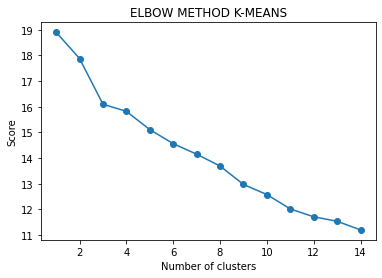

[18.90333761811746, 17.875527366551708, 16.098899562655987, 15.821111107287777, 15.111060750744551, 14.561845749234964, 14.153340526659019, 13.690486129685599, 12.973819463018932, 12.579860951691309, 12.020602319889422, 11.713671637031176, 11.540269569327737, 11.202851935453094]


In [59]:
Score = [] 
X = venues_grpd.drop('Neighborhood',axis = 1)
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    Score.append(km.inertia_) 

# plot
plt.title("ELBOW METHOD K-MEANS")
plt.plot(range(1, 15), Score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()
print(Score)

we can see from above graph and Scores that after Number of Clusters around 4,5 error/Score is not decreasing rapidly So we can assume from this that around 4,5 Clusters will be good for Clustering the Neighborhood

Lets Perform K-Means Using 5 Clusters 

In [107]:
K=5
km = KMeans(
        n_clusters=K, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
km.fit(X)

KMeans(init='random', n_clusters=5, random_state=0)

Lets merger the labels with the Our Neighborhood Data

In [109]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)
dlh_clusters = data_df
dlh_clusters = dlh_clusters.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

In [110]:
print(dlh_clusters.shape)
dlh_clusters

(118, 15)


,Area,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.7204,77.1726,2.0,Jewelry Store,Ice Cream Shop,Astrologer,Light Rail Station,Train Station,Electronics Store,Indian Restaurant,Indian Chinese Restaurant,Garden Center,Garden
1,North West Delhi,Ashok Vihar,28.6904,77.1761,2.0,Snack Place,Indian Restaurant,Sandwich Place,Pizza Place,Market,South Indian Restaurant,BBQ Joint,Asian Restaurant,Coffee Shop,Department Store
2,North West Delhi,Begum Pur,28.7326,77.0521,4.0,Tourist Information Center,ATM,Food & Drink Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
3,North West Delhi,Karala,28.7373,77.0396,4.0,Tourist Information Center,Women's Store,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
4,North West Delhi,Model Town,28.705,77.1895,0.0,Pizza Place,Men's Store,Fast Food Restaurant,Convenience Store,Coffee Shop,Food Truck,Shopping Mall,Snack Place,Bank,Bakery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,West Delhi,Rajouri Garden,28.6456,77.1221,2.0,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Bakery,Dessert Shop,BBQ Joint,Diner,Pub,Restaurant
114,West Delhi,Tihar Village,28.6355,77.1078,0.0,Restaurant,Coffee Shop,Fast Food Restaurant,Multiplex,Shopping Mall,Donut Shop,Bakery,Indian Restaurant,Sculpture Garden,Food Court
115,West Delhi,Tilak Nagar,28.6409,77.0892,0.0,Clothing Store,Donut Shop,Light Rail Station,Furniture / Home Store,Café,Metro Station,Coffee Shop,Fast Food Restaurant,Flea Market,French Restaurant
116,West Delhi,Vikas Nagar,28.6401,77.0344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can see that there is 1 Neighborhood Which have NaN values Lets remove it

In [111]:
dlh_clusters = dlh_clusters.dropna()

Lets check again if we have some nan or blank values

In [112]:
print(dlh_clusters.isnull().sum())

Area                      0
Neighbourhood             0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


We can see that lables are float Lets change them to int so that they won't bother in Visualization

In [113]:
dlh_clusters['Cluster Labels'] = dlh_clusters['Cluster Labels'].astype(int)

<ipython-input-113-1b0e55b53d0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dlh_clusters['Cluster Labels'] = dlh_clusters['Cluster Labels'].astype(int)


### **Lets Visulize the Clusters Using Folium**

In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dlh_clusters['Latitude'], dlh_clusters['Longitude'], dlh_clusters['Neighbourhood'], dlh_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyse Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster

In [140]:
temp_cls = dlh_clusters.drop(['Latitude','Longitude'],axis=1)

#### Cluster 0

In [166]:
temp_cls.loc[temp_cls['Cluster Labels'] == 0].head(10)

,Area,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,North West Delhi,Model Town,0,Pizza Place,Men's Store,Fast Food Restaurant,Convenience Store,Coffee Shop,Food Truck,Shopping Mall,Snack Place,Bank,Bakery
5,North West Delhi,Narela,0,Furniture / Home Store,Multiplex,Women's Store,Golf Course,Garden Center,Garden,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
6,North West Delhi,Pitam Pura,0,Chinese Restaurant,Snack Place,Department Store,Mobile Phone Shop,Multiplex,Women's Store,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
7,North West Delhi,Rohini Sub City,0,Pizza Place,Juice Bar,Multiplex,Food & Drink Shop,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
11,North Delhi,Kamla Nagar,0,Breakfast Spot,Fast Food Restaurant,Pizza Place,Dessert Shop,Café,Chinese Restaurant,Coffee Shop,Donut Shop,Indian Restaurant,Dumpling Restaurant
13,North Delhi,Kotwali,0,Shopping Mall,Convenience Store,Cafeteria,Coffee Shop,Café,Women's Store,Food Truck,Garden,Furniture / Home Store,Frozen Yogurt Shop
16,North Delhi,Sarai Rohilla,0,Fast Food Restaurant,Dessert Shop,Kitchen Supply Store,Light Rail Station,Mobile Phone Shop,Women's Store,Food Court,Garden Center,Garden,Furniture / Home Store
18,North Delhi,Tis Hazari,0,Food Truck,Miscellaneous Shop,Light Rail Station,Metro Station,Women's Store,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
19,North Delhi,Timarpur,0,Asian Restaurant,Tibetan Restaurant,Bus Station,Café,Hotel,Restaurant,Metro Station,Coffee Shop,Food Court,Garden
22,North East Delhi,Naveen Shahdara,0,Light Rail Station,Photography Studio,Vegetarian / Vegan Restaurant,Food,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant


#### Custers 1

In [143]:
temp_cls.loc[temp_cls['Cluster Labels'] == 1]

,Area,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,South Delhi,Chattarpur,1,Coffee Shop,Dessert Shop,Restaurant,Farm,Boutique,Falafel Restaurant,Event Space,Garden Center,Garden,Furniture / Home Store


#### Clusters 2

In [144]:
temp_cls.loc[temp_cls['Cluster Labels'] == 2]

,Area,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,2,Jewelry Store,Ice Cream Shop,Astrologer,Light Rail Station,Train Station,Electronics Store,Indian Restaurant,Indian Chinese Restaurant,Garden Center,Garden
1,North West Delhi,Ashok Vihar,2,Snack Place,Indian Restaurant,Sandwich Place,Pizza Place,Market,South Indian Restaurant,BBQ Joint,Asian Restaurant,Coffee Shop,Department Store
8,North West Delhi,Shalimar Bagh,2,Coffee Shop,Indian Restaurant,Convenience Store,Restaurant,Hotel,Food,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
9,North Delhi,Civil Lines,2,Pizza Place,Donut Shop,Grocery Store,Light Rail Station,Trail,Chinese Restaurant,Hotel,Dessert Shop,Italian Restaurant,Indian Restaurant
10,North Delhi,Gulabi Bagh,2,ATM,Electronics Store,Pizza Place,Indian Restaurant,Train Station,Business Service,Café,Food Court,Garden,Furniture / Home Store
12,North Delhi,Kashmiri Gate,2,Indian Restaurant,Fast Food Restaurant,Market,Snack Place,Bus Station,Pizza Place,Metro Station,Boutique,Dessert Shop,Historic Site
14,North Delhi,Mori Gate; Delhi,2,Indian Restaurant,Snack Place,Fast Food Restaurant,Market,Light Rail Station,Dessert Shop,Boutique,Miscellaneous Shop,Metro Station,Historic Site
15,North Delhi,Sadar Bazaar,2,Indian Restaurant,Indian Sweet Shop,Multiplex,Convenience Store,Shoe Store,Women's Store,Food Court,Garden,Furniture / Home Store,Frozen Yogurt Shop
17,North Delhi,Shakti Nagar,2,Train Station,Indian Restaurant,Light Rail Station,Fast Food Restaurant,Women's Store,Food & Drink Shop,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
21,North East Delhi,Dilshad Garden,2,Pizza Place,Indian Restaurant,Shop & Service,Light Rail Station,Metro Station,Food & Drink Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint


#### Clusters 3

In [145]:
temp_cls.loc[temp_cls['Cluster Labels'] == 3]

,Area,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,North East Delhi,Shastri Park,3,Metro Station,IT Services,Hotel,Women's Store,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
29,Central Delhi,Jhandewalan,3,Indian Restaurant,Hotel,Pizza Place,Light Rail Station,High School,Food,Women's Store,Food Court,Garden,Furniture / Home Store
33,Central Delhi,Paharganj,3,Hotel,Indian Restaurant,Pizza Place,Fast Food Restaurant,Tibetan Restaurant,Breakfast Spot,Snack Place,Café,Bar,Coffee Shop
74,South Delhi,New Friends Colony,3,Hotel,Gym,Café,Food Court,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
76,South Delhi,Okhla,3,Pizza Place,Convenience Store,Hotel,Food & Drink Shop,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
86,South Delhi,Sriniwaspuri,3,Hotel,Flea Market,Café,Shopping Mall,Plaza,Gym,Gym / Fitness Center,Fast Food Restaurant,Coffee Shop,Sculpture Garden
94,South West Delhi,Inderpuri,3,Hotel,Snack Place,Sandwich Place,Indian Restaurant,Multiplex,Arcade,Fast Food Restaurant,Café,Garden,Furniture / Home Store
95,South West Delhi,Mahipalpur,3,Hotel,Indian Restaurant,Road,Women's Store,Food,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
99,South West Delhi,Naraina Vihar,3,Hotel,Café,Snack Place,Pizza Place,Furniture / Home Store,Indian Restaurant,Multiplex,Arcade,Fast Food Restaurant,Sandwich Place


### Clusters 4

In [147]:
temp_cls.loc[temp_cls['Cluster Labels'] == 4]

,Area,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North West Delhi,Begum Pur,4,Tourist Information Center,ATM,Food & Drink Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
3,North West Delhi,Karala,4,Tourist Information Center,Women's Store,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
20,North Delhi,Wazirabad,4,ATM,Accessories Store,Women's Store,Food Court,Golf Course,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
23,North East Delhi,New Usmanpur,4,Tourist Information Center,ATM,Food & Drink Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
26,North East Delhi,Yamuna Vihar,4,Pizza Place,ATM,Food & Drink Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
80,South Delhi,Sangam Vihar,4,ATM,Accessories Store,Shipping Store,Clothing Store,Women's Store,Food Court,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop


### **Result and Discussion**

After analyzing All clusters Data we can see that some clusters are Highly recommended Like Clusters 2 and 3 On the other hand Some Clusters are not good for investing like Clusters 1 and 4. Neighborhoods in clusters 1 and 4 have very less numbers of restaurants, hotels, cafe and Bars in their top 10 common venues. These clusters contain a higher numbers of other venues like ATM, Tourist Information Centre, Clothing store etc. because of this, neighborhood in these Clusters is not well for opening a new Hotel or Paying Guests. Now if we look at clusters 2 and 3 they contain a much higher number of restaurants, hotels, Gym, cafes, pubs etc. and that is why neighborhood in these city are highly recommended for opening a hotel or Paying Guests. Now If we compare 2 and 3 we can clearly see that neighborhood in cluster 2 have more number of food centers, pubs and cafe etc and less number of hotels so for opening a new hotel or paying guests can be beneficial here since there are very less competition in these neighborhood and if we look at clusters 3 there are already more number of hotels so opening a new Hotel or Paying Guests where competition is very high is not recommended. 

Now it is up to the owner what type of customers they are targeting if there target is Students then neighborhood in cluster 2 is very well suited for that since it contains all the things student wants like food centers, cafe, pubs and Gym, snack places etc. Even if target customers are Tourists then cluster 2 is highly recommended. 

### Lets visualiz Clusters 2 on map

In [161]:
cls_2 = dlh_clusters.loc[dlh_clusters['Cluster Labels'] == 2]

In [162]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, location, neighborhood in zip(cls_2['Latitude'], cls_2['Longitude'],
                                            cls_2['Area'], cls_2['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

### Conclusion
We have successfully analyzed the neighborhoods in Delhi, India for determining which would be the best neighborhoods for opening a new Hotel or Paying Guests. Based on our Analysis of Clusters we can clearly see that opening a new Hotel and Paying Guests is Highly recommended in Cluster 2 Since there are very less numbers of hotels or paying guests and High number of food centers, gyms, pubs, snack places etc. that means opening a new Hotel or Paying Guest in these are can be very beneficial since there are less competition and high availability of food and other stuff which every human needs. 

### **Thank You**